In [52]:
import numpy as np
# feature extracture (mfcc) + load wave files
import librosa
# walking on the wave files with different names
import os
from tqdm import tqdm_notebook as tqdm
# to save and load variables
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from IPython import display
# Model
import tensorflow as tf
import tensorflow.keras
from tensorflow import keras
from tensorflow.keras import layers, models, activations, optimizers, losses
from keras.models import Model
from keras.layers import BatchNormalization, CuDNNGRU, Conv1D, MaxPooling1D, Dropout, Dense, GRU, Flatten, Bidirectional
# Machine learning tools for performance comparison
from sklearn.metrics import confusion_matrix, classification_report

In [53]:
#setting
matplotlib.rcParams['figure.figsize'] = (6, 2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [54]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [55]:
#useing to load dataset
loadProccedData = True

In [56]:
# download TIMIT DB
if loadProccedData == False:
  !wget cls.ru.nl/~ltenbosch/TIMIT.tar.gz

In [57]:
# unzip files
if loadProccedData == False:
  !tar -zxvf /content/TIMIT.tar.gz

In [58]:
#calculating the energy of wav files
def energy(wav):
  energ = np.inner(wav, wav)
  return energ
#Normalyzing the wav files
def normaliz(wav):
  wav /= energy(wav)
  return wav

In [59]:
# train set (feature extracting from wav and phonetics from text files)
if loadProccedData == False:
  trainPhonesFeatures = []
  trainPhonesLabels = []
  trainDialectRegion = []
  trainSpeakerID = []
  trainGenderID = []
  # counterCheck = 0
  pathBase = '/content/wavfiles16kHz/TRAIN/'
  # walking on all files
  for path in tqdm(os.listdir(pathBase)):
    # counterCheck += 1
    # if counterCheck == 10 :
    #   break
    wavFile, sampleRate = librosa.load(pathBase+path)
    sampleRate = 16000
    #Normilizing wav file to its energy
    wavFile = normaliz(wavFile)
    # extracting features 
    wavMfccFeatures = librosa.feature.mfcc(y=wavFile, sr=sampleRate,
                                           n_mfcc=13, hop_length=160)
    # print(len(wavFile)/sampleRate * 100)
    # print(np.shape(wavMfccFeatures))
    
    
    # path of text files (.PHN)
    pathToPhn = '/content/PHN/TRAIN/' + os.path.splitext(os.path.basename(path))[0] + '.PHN'
    dialectRegion = path[0 : 3]
    genderID = path[3]
    speakerID = path[3 : 8]

    with open(pathToPhn) as f:
      line = f.readline()
      while line:
        start, end, phoneName = line.split(sep=' ')
        trainPhonesLabels.append(phoneName)
        trainDialectRegion.append(dialectRegion)
        trainSpeakerID.append(speakerID)
        if genderID == 'M':
          trainGenderID.append(0)
        else:
          trainGenderID.append(1)
        #changing start and end of phones into centi_second
        start = np.floor(int(start) / sampleRate * 100).astype(np.int)
        end = np.floor(int(end) / sampleRate * 100).astype(np.int)
        #getting feature slice
        phoneFeatures = wavMfccFeatures[:,start:end]
        trainPhonesFeatures.append(phoneFeatures)
        #next line
        line = f.readline()



In [60]:
# test set (feature extracting from wav and phonetics from text files)
if loadProccedData == False:
  testPhonesFeatures = []
  testPhonesLabels = []
  testDialectRegion = []
  testSpeakerID = []
  testGenderID = []
  counterCheck = 0
  pathBase = '/content/wavfiles16kHz/TEST/'
  # walking on all files
  for path in tqdm(os.listdir(pathBase)):
    # counterCheck += 1
    # if counterCheck == 10 :
    #   break
    wavFile, sampleRate = librosa.load(pathBase+path)
    sampleRate = 16000
    #Normilizing wav file to its energy
    wavFile = normaliz(wavFile)
    # extracting features 
    wavMfccFeatures = librosa.feature.mfcc(y=wavFile, sr=sampleRate, n_mfcc=13, hop_length=160)
    # path of text files (.PHN)
    # print(len(wavFile)/sampleRate * 100)
    # print(np.shape(wavMfccFeatures))
    pathToPhn = '/content/PHN/TEST/' + os.path.splitext(os.path.basename(path))[0] + '.PHN'
    dialectRegion = path[0:3]
    genderID = path[3]
    speakerID = path[3 : 8]

    with open(pathToPhn) as f:
      line = f.readline()
      while line:
        start, end, phoneName = line.split(sep=' ')
        testPhonesLabels.append(phoneName)
        testDialectRegion.append(dialectRegion)
        testSpeakerID.append(speakerID)
        if genderID == 'M':
          testGenderID.append(0)
        else:
          testGenderID.append(1)
        #changing start and end of phones into centi_second
        start = np.floor(int(start) / sampleRate * 100).astype(np.int)
        end = np.floor(int(end) / sampleRate * 100).astype(np.int)
        #getting feature slice
        phoneFeatures = wavMfccFeatures[:,start:end]
        testPhonesFeatures.append(phoneFeatures)
        #next line
        line = f.readline()



In [61]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [62]:
#saving the variables
if loadProccedData == False:
  AllVars = [trainPhonesFeatures, trainPhonesLabels, trainDialectRegion, trainSpeakerID,
            testPhonesFeatures, testPhonesLabels, testDialectRegion, testSpeakerID,trainGenderID , testGenderID]
  with open('/content/gdrive/MyDrive/Dataset/TIMITData/' + 'DS.pckl', 'wb') as f:
      pickle.dump(AllVars, f)

In [63]:
#load the variables
if loadProccedData:
  with open('/content/gdrive/MyDrive/Dataset/TIMITData/' + 'DS.pckl', 'rb') as f:
    [trainPhonesFeatures, trainPhonesLabels,
    trainDialectRegion, trainSpeakerID,
    testPhonesFeatures, testPhonesLabels, 
    testDialectRegion, testSpeakerID, trainGenderID, testGenderID] = pickle.load(f)

In [64]:
# check the number of phones which have the length less than 7
c = 0
for ph in trainPhonesFeatures:
  if np.size(ph, axis=1) < 7:
    c += 1

print ('the number of phones with len less than 7 =', c)
# as there are almost half of training data with len less than 7 we should use padding

# check the number of phones which have the length less than 7
c = 0
for ph in trainPhonesFeatures:
  if np.size(ph, axis=1) % 7 < 4:
    c += 1

print ('............................... =', c)
# as there are almost half of training data with len less than 7 we should use padding

# check the number of phones which have the length less than 7
c = 0
for ph in trainPhonesFeatures:
  if np.size(ph, axis=1) % 7 != 0:
    c += 1

print ('the number of phones with len less than 4 =', c)
# as there are almost half of training data with len less than 7 we should use padding

the number of phones with len less than 7 = 85162
............................... = 95636
the number of phones with len less than 4 = 154938


In [65]:
w = set(trainPhonesLabels)
print(w)
print('the number of unique phones = ', len(w))
# the number of training data
trainNumbers = len(trainPhonesLabels)
# the number of test data
testNumbers = len(testPhonesLabels)
print('the number of training data = ', trainNumbers)
print('the number of test data = ', testNumbers)

{'f\n', 't\n', 'm\n', 'em\n', 'hv\n', 'dx\n', 'ae\n', 'b\n', 'gcl\n', 'ah\n', 'aa\n', 'th\n', 'iy\n', 'g\n', 'ch\n', 'ax\n', 'nx\n', 'uw\n', 'hh\n', 'aw\n', 'q\n', 'n\n', 'v\n', 'l\n', 'eng\n', 'ux\n', 'er\n', 'ow\n', 'pau\n', 's\n', 'z\n', 'en\n', 'axr\n', 'y\n', 'w\n', 'zh\n', 'dh\n', 'ng\n', 'ix\n', 'h#\n', 'k\n', 'r\n', 'tcl\n', 'epi\n', 'oy\n', 'ay\n', 'bcl\n', 'ih\n', 'pcl\n', 'ax-h\n', 'ey\n', 'dcl\n', 'p\n', 'ao\n', 'jh\n', 'sh\n', 'el\n', 'eh\n', 'd\n', 'kcl\n', 'uh\n'}
the number of unique phones =  61
the number of training data =  177080
the number of test data =  64145


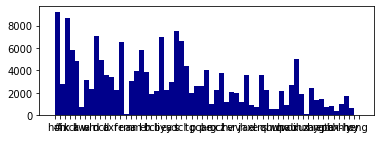

In [66]:
plt.hist(trainPhonesLabels, bins=61, color='darkblue');

In [67]:
#removing '\n' from phonetics
trainPhonesLabels = [x.strip() if x is not None else '' for x in trainPhonesLabels]
testPhonesLabels = [x.strip() if x is not None else '' for x in testPhonesLabels]
w = set(trainPhonesLabels)
print(w)

{'dcl', 'v', 'uh', 'ow', 'ux', 'pau', 'bcl', 'h#', 'z', 'zh', 'hh', 'r', 't', 'w', 'ao', 'dx', 'eng', 'ng', 'gcl', 'g', 'p', 'en', 'ae', 'epi', 'ay', 'y', 'ah', 'pcl', 'k', 'nx', 'f', 'eh', 'dh', 'er', 'ey', 'ax', 'aa', 'oy', 'sh', 'ix', 'em', 's', 'uw', 'm', 'q', 'b', 'aw', 'el', 'th', 'ch', 'hv', 'kcl', 'axr', 'tcl', 'jh', 'ih', 'n', 'd', 'l', 'iy', 'ax-h'}


In [68]:
# import librosa.display
# #check some parameters
# yyy, sr = librosa.load('/content/DR1FCJF0SA1.WAV')
# sr = 16000
# print('length of first wav file: ', len(yyy))
# print('sample rate: ', sr)
# print('length of wav file in second: ', len(yyy)/sr)
# print('N is: ', len(yyy)/sr*100)
# x = librosa.feature.mfcc(y=yyy, sr=sr)
# print('with default parameters: ', np.shape(x))
# #n_mfcc is the number of coeficients in MFCC-feature extracting
# x = librosa.feature.mfcc(y=yyy, sr=sr , n_mfcc=13, hop_length=160)
# print('after tuning parameters: ', np.shape(x))
# y_harm, y_perc = librosa.effects.hpss(yyy)
# librosa.display.waveplot(yyy, sr=sr);
# plt.show()
# fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
# librosa.display.waveplot(y_harm, sr=sr, alpha=0.25, ax=ax[2])
# librosa.display.waveplot(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[2])
# ax[2].set(title='Harmonic + Percussive')
# plt.show()
# librosa.display.waveplot(yyy[0:100], sr=sr);
# plt.show()

In [69]:
cq = 0
for i in trainPhonesLabels:
  if i == 'q':
    cq += 1

print(cq)


cq = 0
for i in testPhonesLabels:
  if i == 'q':
    cq += 1

print(cq)

3590
1244


##Labling the phones

\begin{array}{|c|c|c|c}\hline
\mathcal{\#} & \mathcal{Phone Class} & \mathcal{\# labels} & \mathcal{TIMIT labels} \\ \hline
  l1 & Vowel/Semivowel(VS) & 25 & aa \ ae \ ah \ ao \ aw \ ax \ axh \ axr \ ay \ eh \ er \ ey \ ih \ ix \ iy \ ow \ oy \ uh \ uw \ ux \ el \ l \ r \ w \ y \\ \hline
  l2 & Nasal/Flap(NF) & 8 & em \ en \ eng \ m \ n \ ng \ nx \ dx \\ \hline
  l3 & Strong Fracative(SF) & 6 & s \ z \ sh \ zh \ ch \ jh \\ \hline
  l4 & Weak Fricative(Wf) & 6 & v \ f \ dh \ th \ hh \ hv \\ \hline
  l5 & Stop(ST) & 6 & d \ b \ g \ p\ t\ k \\ \hline
  l6 & Closure (CL) & 9 & bcl \ dcl \ gcl \ pcl \ tcl \ kcl \ epi \ pau \ h\# \\ \hline \hline
  l7 & Sonorant(SON) & 33 & Vowel/Semivowel + Nasal/Flap \\ \hline
  l8 & Obstruent (OBS) & 18 & Strong Fric + Weak Fric + Stop\\ \hline
  l9 & Silence (SIL) & 9 & Same as Closure\\ \hline
  \end{array}

In [70]:
phLabels1998 = {0: ['aa', 'ae', 'ah', 'ao', 'aw', 'ax', 'axh', 'axr', 'ay', 'eh', 
                'er', 'ey', 'ih', 'ix', 'iy', 'ow', 'oy', 'uh', 'uw', 'ux', 'el',
                 'l', 'r', 'w', 'y']
            ,1: ['em', 'en', 'eng', 'm', 'n', 'ng', 'nx', 'dx']
            ,2: ['s', 'z', 'sh', 'zh', 'ch', 'jh']
            ,3: ['v', 'f', 'dh', 'th', 'hh', 'hv']
            ,4: ['d', 'b', 'g', 'p', 't', 'k']
            ,5: ['bcl', 'dcl', 'gcl', 'pcl', 'tcl', 'kcl', 'epi', 'pau', 'h#']
            }

In [71]:
# assigning the labels to one of 6 classes
# training data
trainPhoneLabelsConverted = np.zeros((trainNumbers), dtype=np.int)
cnt = 0
for label in trainPhonesLabels:
  for i in range(6):
    if label in phLabels1998[i]:
      trainPhoneLabelsConverted[cnt] = i
      cnt += 1
      break
print(set(trainPhoneLabelsConverted))

{0, 1, 2, 3, 4, 5}


In [72]:
# test data
testPhoneLabelsConverted = np.zeros((testNumbers), dtype=np.int)
cnt = 0
for label in testPhonesLabels:
  for i in range(6):
    if label in phLabels1998[i]:
      testPhoneLabelsConverted[cnt] = i
      cnt += 1
      break
print(set(testPhoneLabelsConverted))

{0, 1, 2, 3, 4, 5}


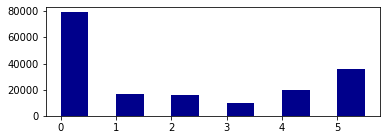

In [73]:
plt.hist(trainPhoneLabelsConverted, color='darkblue', bins=np.arange(0, 12)/2);

In [74]:
# check the number of phones which have the length less than 7
c = 0
for i in range(len(trainPhonesFeatures)):
  if trainPhoneLabelsConverted[i] == 5 and trainPhonesFeatures[i].shape[1]  > 20:
    c += 1

c /= np.sum(trainPhoneLabelsConverted == 5)
print ( c)

0.02555955068706971


In [75]:
#preprocessing on mfcc_features stacking size - zero padding
cntTrain = 0
for ph in trainPhonesFeatures:
  cntTrain += np.size(ph, axis=1) // 7
  if np.size(ph, axis=1) % 7 > 3:
    cntTrain += 1

print(cntTrain)
# for instnace for len(ph) = 15 we have 3 frames of size 13*7 = 91

cntTest = 0
for ph in testPhonesFeatures:
  cntTest += np.size(ph, axis=1) // 7
  if np.size(ph, axis=1) % 7 > 3:
    cntTest += 1

print(cntTest)

203755
74382


In [76]:
# we should have 277249 training data with dimention 299391*91
Xtr = np.zeros((cntTrain, 91))
ytr = np.zeros((cntTrain))
i = 0 # for counting train phones (transfering labels)
j = 0 # for counting splited training phones

for ph in trainPhonesFeatures:
  while np.size(ph, axis=1) >= 7:
    temp = ph[:, 0:7]
    Xtr[j] = temp.flat #adding first 7 columns to Xtrain as supervector
    ytr[j] = trainPhoneLabelsConverted[i]
    j += 1
    # ph = np.delete(ph, range(7), axis=1)
    ph = ph[:, 7:]
  if np.size(ph, axis=1) > 3:
    temp = ph.flat
    Xtr[j, 0:len(temp)] = temp
    ytr[j] = trainPhoneLabelsConverted[i]
    j += 1
  i += 1

In [77]:
ph_t = trainPhonesFeatures[6]
# print(ph_t)
ph_t2 = ph_t[:, 7:]
ph_t3 = np.delete(ph_t, range(7), axis=1)
# print(ph_t2)

In [78]:
# we should have 101012 test data with dimention 299391*91
Xtst = np.zeros((cntTest, 91))
ytst = np.zeros((cntTest))
i = 0 # for counting test phones (transfering labels)
j = 0 # for counting splited test phones

for ph in testPhonesFeatures:
  while np.size(ph, axis=1) >= 7:
    temp = ph[:, 0:7]
    Xtst[j] = temp.flat #adding first 7 columns to Xtest as supervector
    ytst[j] = testPhoneLabelsConverted[i]
    j += 1
    ph = np.delete(ph, range(7), axis=1)
  if np.size(ph, axis=1) > 3:
    temp = ph.flat
    Xtst[j, 0:len(temp)] = temp
    ytst[j] = testPhoneLabelsConverted[i]
    j += 1
  i += 1

In [79]:
#one_hot the labels
nClasses = 6
ytrOneHot = tf.keras.utils.to_categorical(ytr, num_classes=nClasses, dtype='float32')

In [80]:
#Data Normalizing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(Xtr)
Xtr = scaler.transform(Xtr)
Xtst = scaler.transform(Xtst)

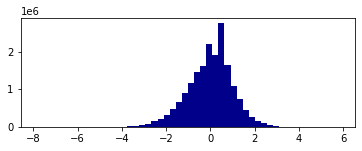

In [81]:
#standardized MFCC features
plt.hist(Xtr.reshape(-1), bins=50, color='darkblue');
#the dist is normal and doesn't need to clip

tf.Tensor([91122. 19235. 18036. 11453. 22445. 41464.], shape=(6,), dtype=float32)


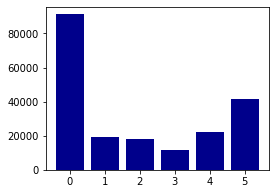

In [82]:
one_hot_labels = np.array(ytrOneHot)
count_label = tf.reduce_sum(one_hot_labels, axis=0)
print(count_label) 
fig = plt.figure(figsize=(4, 3))
bar_width = 0.8
p1 = plt.bar(np.arange(6), count_label, bar_width, color='darkblue', label='John')

In [83]:
# #smote for umsampling (Synthetic Minority Oversampling Technique)
# from imblearn.over_sampling import SMOTE
# # ytr = ytr_2class
# # ytst = ytst_2class
# # transform the dataset
# oversample = SMOTE()
# XtrU, ytrU = oversample.fit_resample(Xtr, ytr)
# # # define pipeline
# # over = SMOTE(sampling_strategy=0.1)
# # under = RandomUnderSampler(sampling_strategy=0.5)
# # steps = [('o', over), ('u', under)]
# # pipeline = Pipeline(steps=steps)

# from sklearn.tree import DecisionTreeClassifier
# # the deeper tree, the more probable to get overfitted
# clf = DecisionTreeClassifier(random_state=0, max_depth=7)
# clf = clf.fit(XtrU, ytrU)

# ypredtree = clf.predict(Xtst)
# print(classification_report(ytst, ypredtree))

In [84]:
# plt.hist(ytrU)

##Biulding the Network

In [85]:
# !pip install keras-balanced-batch-generator
# keras-balanced-batch-generator
# URL: https://github.com/soroushj/keras-balanced-batch-generator
# from keras_balanced_batch_generator import make_generator
# generator = make_generator(Xtr, ytrOneHot, batch_size=32)

In [86]:
#Data Balancing with keras generator
# from imblearn.keras import balanced_batch_generator
# from imblearn.under_sampling import NearMiss
# training_generator, steps_per_epoch = balanced_batch_generator(
#     Xtr, ytrOneHot, sampler=NearMiss(), batch_size=10, random_state=42)


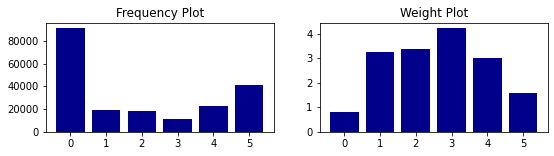

class0 : numbers is 91122 so its weight is 0.804719023720987
class1 : numbers is 19235 so its weight is 3.254678103207411
class2 : numbers is 18036 so its weight is 3.361120046396683
class3 : numbers is 11453 so its weight is 4.217882790090766
class4 : numbers is 22445 so its weight is 3.012966705278972
class5 : numbers is 41464 so its weight is 1.5920927108097693


In [87]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
classCounts = np.histogram(ytr, bins=len(set(ytr)))[0]
total = len(ytr)
weight_for_0 = np.log((1 / classCounts[0])*(total))
weight_for_1 = np.sqrt((1 / classCounts[1])*(total))
weight_for_2 = np.sqrt((1 / classCounts[2])*(total))
weight_for_3 = np.sqrt((1 / classCounts[3])*(total))
weight_for_4 = np.sqrt((1 / classCounts[4])*(total))
weight_for_5 = np.log((1 / classCounts[5])*(total))

class_weight = {0: weight_for_0, 1: weight_for_1,
                2: weight_for_2, 3: weight_for_3,
                4: weight_for_4, 5: weight_for_5}


fig = plt.figure(figsize=(9, 2))
ax1 = fig.add_subplot(121)
p1 = plt.bar(np.arange(6), count_label, bar_width,
             color='darkblue', label='John')
ax2 = fig.add_subplot(122)
array = np.array(list(class_weight.items()), dtype=np.float32)[:,1]
plt.bar(range(0, 6), array, color='darkblue')
ax1.title.set_text('Frequency Plot')
ax2.title.set_text('Weight Plot')
plt.show()

for i in range(6):
  print('class' + str(i) + ' : ' + 
        'numbers is ' + str(int(count_label.numpy()[i])) +
        ' so its weight is ' + str(class_weight[i]))

In [88]:
# from sklearn.svm import SVC
# # ytr = ytr_2class
# # ytst = ytst_2class
# # classweight = {0: 1, 1: 3}
# svm = SVC(class_weight=class_weight, kernel = 'linear')
# svm.fit(Xtr, ytr)
# ypredsvm = svm.predict(Xtst)
# print(classification_report(ytst, ypredsvm))

In [89]:
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_prc', 
#     verbose=1,
#     patience=10,
#     mode='max',
#     restore_best_weights=True)

In [90]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [91]:
def build_neural_network(data_size_in, n_classes, output_bias=None):
  #if output_bias is not None:
   # output_bias = tf.keras.initializers.Constant(output_bias)
  # He is more compatible with relu and Glorot is more adjustable with tanh
  initializer = tf.keras.initializers.HeUniform()

  inputs = layers.Input(shape=data_size_in)
  x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(inputs)

  #First Conv1D layer
  x = Conv1D(32, 3, padding='same', activation='gelu', strides=1)(inputs)
  x = MaxPooling1D(2)(x)
  x = Dropout(0.3)(x)


  #Second Conv1D layer
  x = Conv1D(64, 3, padding='same', activation='gelu', strides=1)(x)
  x = Conv1D(64, 3, padding='same', activation='gelu', strides=1)(x)
  x = Conv1D(128, 3, padding='same', activation='gelu', strides=1)(x)
  x = Conv1D(128, 3, padding='same', activation='gelu', strides=1)(x)
  x = Conv1D(256, 3, padding='same', activation='gelu', strides=1)(x)
  x = Conv1D(256, 3, padding='same', activation='gelu', strides=1)(x)
  x = Conv1D(512, 3, padding='same', activation='gelu', strides=1)(x)
  x = Conv1D(512, 3, padding='same', activation='gelu', strides=1)(x)
  x = Conv1D(1024, 3, padding='same', activation='gelu', strides=1)(x)
  
  x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation='gelu', kernel_initializer=initializer)(x)
  x = layers.Dense(1024, activation='gelu')(x)
  x = layers.Dropout(0.3)(x)

  prediction = layers.Dense(n_classes, activation='softmax')(x)#, bias_initializer=output_bias)(x)

  model = Model(inputs=inputs, outputs=prediction)
  
  
  return model

In [92]:
#compile the model
data_size_in = (91, 1)   #13*7
n_classes = 6   #we have 6 different labels
ls = 'categorical_crossentropy'
opt = optimizers.Adam(learning_rate=0.0001, beta_1=0.999, beta_2=0.999)

network = build_neural_network(data_size_in, n_classes)
network.compile(loss=ls, optimizer=opt, metrics=METRICS)
network.summary()

The following Variables were used a Lambda layer's call (tf.compat.v1.nn.conv1d_20), but
are not present in its tracked objects:
  <tf.Variable 'conv1d_20/kernel:0' shape=(3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_20), but
are not present in its tracked objects:
  <tf.Variable 'conv1d_20/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.conv1d_21), but
are not present in its tracked objects:
  <tf.Variable 'conv1d_21/kernel:0' shape=(3, 32, 64) dtype=float32>
It is possible that this is i

Epoch 1/64
5413/5413 [==============================] - 124s 22ms/step - loss: 3.3669 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 216677.2973 - fn: 43335.9970 - accuracy: 0.8333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6596 - prc: 0.2640 - val_loss: 1.7308 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 942518.3125 - val_fn: 188501.9531 - val_accuracy: 0.8333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6842 - val_prc: 0.2700
Epoch 2/64
5413/5413 [==============================] - 120s 22ms/step - loss: 3.3625 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1235450.7674 - fn: 247090.3395 - accuracy: 0.8334 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6881 - prc: 0.2784 - val_loss: 1.7297 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1961284.0000 - val_fn: 392260.5938 - val_accuracy: 0.8333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6887 - val_prc: 0.2851
Epoch 3/64
5413/5413 [==============================] - 120s 22ms/ste

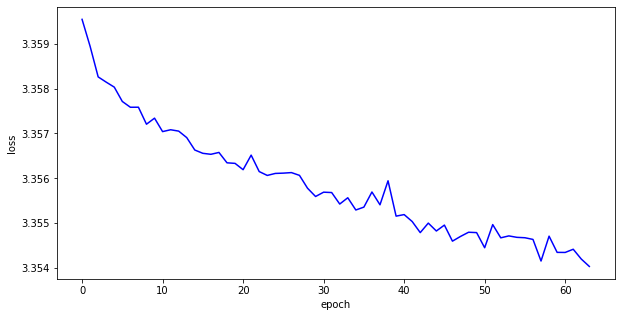

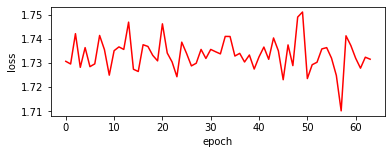

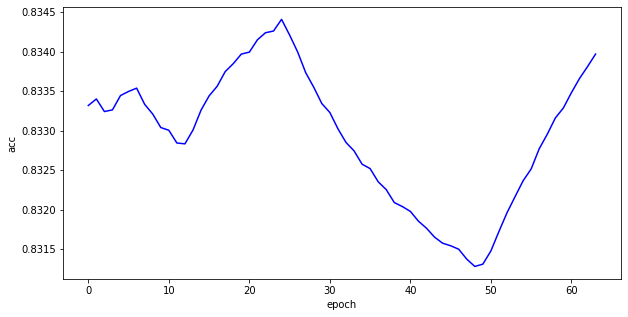

Text(0, 0.5, 'acc')

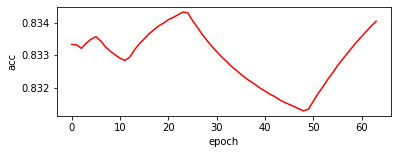

In [93]:
#feed the network
# lists where we will be storing values during training, for visualization purposes
traLosses = [] # list for training loss
traAccs = [] # list for training accuracy
valLosses = [] # list for validation loss
valAccs = [] # list for validation accuracy
batchSize = 32
nEpochs = 64

# Train your network
results = network.fit(Xtr, ytrOneHot, 
                      batch_size=batchSize, 
                      validation_split=0.15, 
                      epochs = nEpochs, verbose = 1,
                      # callbacks=[early_stopping],
                      # The class weights go here
                      class_weight=class_weight)

# Get training loss and accuracy
traLosses = results.history['loss']
traAccs = results.history['accuracy']
valLosses = results.history['val_loss']
valAccs = results.history['val_accuracy']

# Visualization of the learning curves
fig = plt.figure(figsize=(10, 5))
plt.plot(range(len(traLosses)), traLosses, 'b')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.plot(range(len(valLosses)), valLosses, 'r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.plot(range(len(traAccs)), traAccs, 'b')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()
plt.plot(range(len(valAccs)), valAccs, 'r')
plt.xlabel('epoch')
plt.ylabel('acc')
# plt.legend({"train_acc", "val_acc"}, 
          # loc='center left', bbox_to_anchor=(1, 0.5))
# display.display(plt.gcf())

In [94]:
#prediction phase
yPred = network.predict(Xtr)
yPred = np.argmax(yPred, axis=1)

In [95]:
print(classification_report(ytr, yPred))

              precision    recall  f1-score   support

         0.0       0.45      0.44      0.45     91122
         1.0       0.11      0.04      0.06     19235
         2.0       0.11      0.01      0.02     18036
         3.0       0.12      0.00      0.00     11453
         4.0       0.12      0.41      0.18     22445
         5.0       0.22      0.14      0.17     41464

    accuracy                           0.28    203755
   macro avg       0.19      0.17      0.15    203755
weighted avg       0.29      0.28      0.26    203755



In [96]:
print(confusion_matrix(ytr, yPred))
yPred[13]

[[40485  3221   676    43 34711 11986]
 [ 8420   827   144     6  7307  2531]
 [ 7814   646   172     9  6975  2420]
 [ 5030   383   100     9  4453  1478]
 [ 9540   708   137     6  9165  2889]
 [17926  1424   311     5 15899  5899]]


5

In [97]:
#merging train and test data (for gender generalizing)
#providing gender train-test data
trainPhonesFeatures_genderMale = []
for i in range(len(trainGenderID)):
  if trainGenderID[i] == 0:
    trainPhonesFeatures_genderMale.append(trainPhonesFeatures[i])

for i in range(len(testGenderID)):
  if testGenderID[i] == 0:
    trainPhonesFeatures_genderMale.append(testPhonesFeatures[i])

testPhonesFeatures_genderFemale = []
for i in range(len(trainGenderID)):
  if trainGenderID[i] == 1:
    testPhonesFeatures_genderFemale.append(trainPhonesFeatures[i])

for i in range(len(testGenderID)):
  if testGenderID[i] == 1:
    testPhonesFeatures_genderFemale.append(testPhonesFeatures[i])

#trainPhonesFeatures_genderMale = trainPhonesFeatures[trainGenderID == 0]
#trainPhonesFeatures_genderMale = np.concatenate((trainPhonesFeatures_genderMale, testPhonesFeatures[testGenderID == 0]), axis =0)
# testPhonesFeatures_genderFemale = trainPhonesFeatures[trainGenderID == 1]
# testPhonesFeatures_genderFemale = np.concatenate((testPhonesFeatures_genderFemale, testPhonesFeatures[testGenderID == 1]), axis =0)

#providing train-test labels
trainPhonesLabels_genderMale = trainPhoneLabelsConverted[np.array(trainGenderID) == 0]
trainPhonesLabels_genderMale = np.concatenate((trainPhonesLabels_genderMale, testPhoneLabelsConverted[np.array(testGenderID) == 0]), axis =0)

testPhonesLabels_genderFemale = trainPhoneLabelsConverted[np.array(trainGenderID) == 1]
testPhonesLabels_genderFemale = np.concatenate((testPhonesLabels_genderFemale, testPhoneLabelsConverted[np.array(testGenderID) == 1]), axis =0)


In [98]:
#preprocessing on mfcc_features stacking size - zero padding
cntTrainG = 0
for ph in trainPhonesFeatures_genderMale:
  cntTrainG += np.size(ph, axis=1) // 7
  if np.size(ph, axis=1) % 7 != 0:
    cntTrainG += 1

print(cntTrainG)
# for instnace for len(ph) = 15 we have 3 frames of size 13*7 = 91

cntTestG = 0
for ph in testPhonesFeatures_genderFemale:
  cntTestG += np.size(ph, axis=1) // 7
  if np.size(ph, axis=1) % 7 != 0:
    cntTestG += 1

print(cntTestG)

260233
118028


In [99]:
# we should have 277249 training data with dimention 299391*91
XtrG = np.zeros((cntTrainG, 91))
ytrG = np.zeros((cntTrainG))
i = 0 # for counting train phones (transfering labels)
j = 0 # for counting splited training phones

for ph in trainPhonesFeatures_genderMale:
  while np.size(ph, axis=1) >= 7:
    temp = ph[:, 0:7]
    XtrG[j] = temp.flat #adding first 7 columns to Xtrain as supervector
    ytrG[j] = trainPhonesLabels_genderMale[i]
    j += 1
    ph = np.delete(ph, range(7), axis=1)
  if np.size(ph, axis=1) > 3:
    temp = ph.flat
    XtrG[j, 0:len(temp)] = temp  
    j += 1
  i += 1

In [100]:
# we should have 101012 test data with dimention 299391*91
XtstG = np.zeros((cntTestG, 91))
ytstG = np.zeros((cntTestG))
i = 0 # for counting test phones (transfering labels)
j = 0 # for counting splited test phones

for ph in testPhonesFeatures_genderFemale:
  while np.size(ph, axis=1) >= 7:
    temp = ph[:, 0:7]
    XtstG[j] = temp.flat #adding first 7 columns to Xtest as supervector
    ytstG[j] = testPhonesLabels_genderFemale[i]
    j += 1
    ph = np.delete(ph, range(7), axis=1)
  if np.size(ph, axis=1) > 3:
    temp = ph.flat
    XtstG[j, 0:len(temp)] = temp
    j += 1
  i += 1

In [101]:
#one_hot the labels
nClasses = 6
ytrOneHotG = tf.keras.utils.to_categorical(ytrG, num_classes=nClasses, dtype='float32')

In [102]:
#Data Normalizing
scaler = StandardScaler()
scaler.fit(XtrG)
XtrG = scaler.transform(XtrG)
XtstG = scaler.transform(XtstG)

In [103]:
networkG = build_neural_network(data_size_in, n_classes)
networkG.compile(loss=ls, optimizer=opt, metrics=METRICS)

The following Variables were used a Lambda layer's call (tf.compat.v1.nn.conv1d_30), but
are not present in its tracked objects:
  <tf.Variable 'conv1d_30/kernel:0' shape=(3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_30), but
are not present in its tracked objects:
  <tf.Variable 'conv1d_30/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.conv1d_31), but
are not present in its tracked objects:
  <tf.Variable 'conv1d_31/kernel:0' shape=(3, 32, 64) dtype=float32>
It is possible that this is i

In [ ]:
#feed the network
# lists where we will be storing values during training, for visualization purposes
traLosses = [] # list for training loss
traAccs = [] # list for training accuracy
valLosses = [] # list for validation loss
valAccs = [] # list for validation accuracy
batchSize = 32
nEpochs = 32

# Train your network
results = networkG.fit(XtrG, ytrOneHotG, 
                      batch_size=batchSize, 
                      validation_split=0.2, 
                      epochs = nEpochs, verbose = 1,
                      # callbacks=[early_stopping],
                      # The class weights go here
                      class_weight=class_weight)

# Get training loss and accuracy
traLosses = results.history['loss']
traAccs = results.history['accuracy']
valLosses = results.history['val_loss']
valAccs = results.history['val_accuracy']

# Visualization of the learning curves
fig = plt.figure(figsize=(10, 5))
plt.plot(range(len(traLosses)), traLosses, 'b')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()
plt.plot(range(len(valLosses)), valLosses, 'r')
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.legend({"train_loss", "val_loss"}, 
#           loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.plot(range(len(traAccs)), traAccs, 'b')
plt.xlabel('epoch')
plt.ylabel('acc')

plt.show()
plt.plot(range(len(valAccs)), valAccs, 'r')
plt.xlabel('epoch')
plt.ylabel('acc')
# plt.legend({"train_acc", "val_acc"}, 
          # loc='center left', bbox_to_anchor=(1, 0.5))
# display.display(plt.gcf())

Epoch 1/32
6506/6506 [==============================] - 154s 23ms/step - loss: 2.0045 - tp: 20193.2820 - fp: 975.0824 - tn: 65461347.4886 - fn: 13072213.5462 - accuracy: 0.8343 - precision: 0.7752 - recall: 0.0015 - auc: 0.6844 - prc: 0.2725 - val_loss: 5.3048e-05 - val_tp: 116491.5078 - val_fp: 1526.0000 - val_tn: 66371856.0000 - val_fn: 13158235.0000 - val_accuracy: 0.8355 - val_precision: 0.9869 - val_recall: 0.0088 - val_auc: 0.6885 - val_prc: 0.2864
Epoch 2/32
6506/6506 [==============================] - 153s 24ms/step - loss: 1.8184 - tp: 165982.7390 - fp: 1526.0000 - tn: 66762255.4504 - fn: 13186659.7616 - accuracy: 0.8361 - precision: 0.9908 - recall: 0.0124 - auc: 0.6908 - prc: 0.2928 - val_loss: 1.2994e-05 - val_tp: 262399.3438 - val_fp: 1526.0000 - val_tn: 67673000.0000 - val_fn: 13272436.0000 - val_accuracy: 0.8373 - val_precision: 0.9942 - val_recall: 0.0194 - val_auc: 0.6953 - val_prc: 0.3046
Epoch 3/32
6506/6506 [==============================] - 153s 24ms/step - loss: 1

In [ ]:
yPredG = networkG.predict(XtstG)
yPredG = np.argmax(yPredG, axis=1)
print(classification_report(ytstG, yPredG))

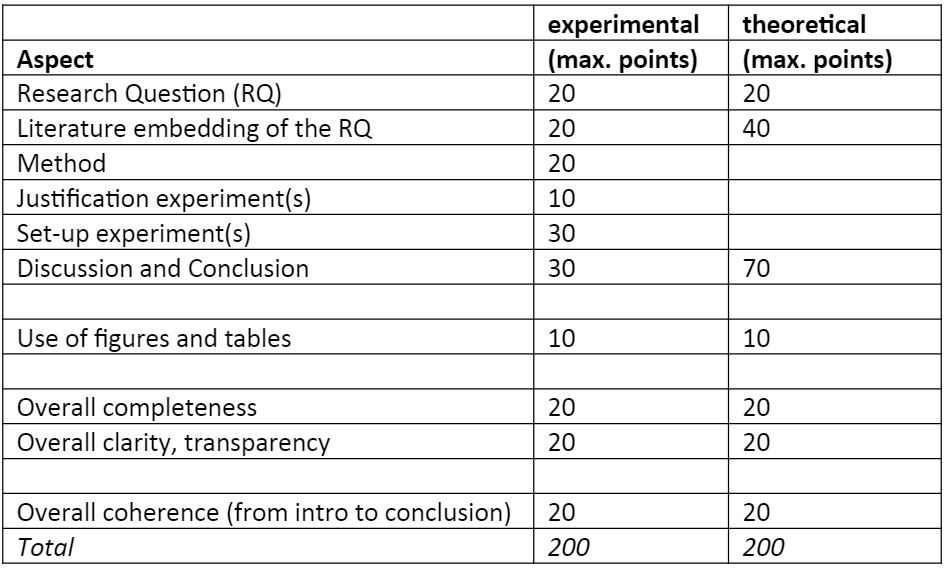